In [ ]:
!pip install lpips
import lpips
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import sys

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
class DataLoader:
    def __init__(self, dataset, ratio = [0.75, 0.2, 0.05], batch_size = 64):
        self.dataset = dataset
        train_data, val_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * ratio) for ratio in ratio])
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
        print(f"Train size: {len(train_data)}")


cifar10 = DataLoader(
    torchvision.datasets.CIFAR10(root='datasets/', train=True, download=True, transform=torchvision.transforms.ToTensor()),
)
stl10 = DataLoader(
    torchvision.datasets.STL10(root='datasets/', download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
)

100%|██████████| 170498071/170498071 [00:02<00:00, 70003128.68it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets/
Train size: 37500


100%|██████████| 2640397119/2640397119 [03:09<00:00, 13921170.45it/s]


Extracting datasets/stl10_binary.tar.gz to datasets/
Train size: 3750


In [ ]:
class TrainStats:
    def __init__(self, epochs):
        self.total_time = 0.0
        self.total_epochs = epochs
        self.losses = []
        self.images = torch.Tensor()

    def add_image(self, images):
        self.images = torch.cat((self.images.cpu(), images.cpu()), dim=2).cpu()

    def show_images(self, filename = None):
        plt.figure(figsize=(10,10))
        npimage = torchvision.utils.make_grid(self.images).cpu().numpy()
        npimage = npimage.transpose(1, 2, 0)
        plt.imshow(npimage)
        if filename:
            plt.imsave(filename, npimage)
        plt.show()

    def plot_loss(self, filename = None):
        plt.figure(figsize=(10,10))
        plt.plot(*zip(*self.losses))
        plt.xticks(np.linspace(0, self.total_epochs - 1, num=10))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        if filename:
            plt.savefig(filename)
        plt.show()

    def __str__(self):
        total_time_formatted = (f"{int(self.total_time):d} seconds" if self.total_time < 60 else
                                f"{int(self.total_time // 60):d}:{int(self.total_time % 60):02d} minutes" if self.total_time < 3600 else
                                f"{int(self.total_time // 3600):d}:{int((self.total_time % 3600) // 60):02d}:{int(self.total_time % 60):02d} hours")
        s =  f"*** Statistics ***\n"
        s += f"Total time: {total_time_formatted}\nTime per epoch: {(self.total_time / self.total_epochs):.2f} seconds\n"
        s += f"Final loss: {self.losses[-1][1]:.5f} after {self.total_epochs} epochs\n"
        s += f"******************\n"
        return s

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoder_layers, decoder_layers, loss_function = nn.MSELoss(), opt_type = optim.Adam, learning_rate = 0.001,
                 scheduler_type = None, scheduler_lambda = None):
        super().__init__()
        self.encoder = encoder_layers.to(device)
        self.decoder = decoder_layers.to(device)
        self.loss_function = loss_function
        self.optimizer = opt_type(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=learning_rate)
        self.scheduler = scheduler_type(self.optimizer, scheduler_lambda) if scheduler_type is not None else None

    def forward(self, input):
        #print(input.shape)
        intermediate = self.encoder(input)
        #print(intermediate.shape)
        output = self.decoder(intermediate)
        #print(output.shape)
        return output

    def train_model(self, loader : DataLoader, epochs = 5, image_interval = 1):
        stats = TrainStats(epochs)
        for epoch in range(0, epochs):
            print(f"Epoch {epoch + 1}")
            epoch_start_time = time.time()
            for input, _ in loader.train_loader:
                input = input.to(device)
                self.optimizer.zero_grad()
                output = self.forward(input)
                loss = self.loss_function(output, input)
                loss.backward()
                self.optimizer.step()

            self.eval()
            total_error = 0.0
            data_size = 0
            with torch.no_grad():
                for input, _ in loader.val_loader:
                    input = input.to(device)
                    output = self.forward(input)
                    total_error += self.loss_function(output, input)
                    data_size += len(input)
            if (self.scheduler is not None):
                self.scheduler.step()

            stats.losses.append((epoch, total_error / data_size))
            print(f"{self.loss_function._get_name()}: {(total_error / data_size):.5f}")

            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            stats.total_time += epoch_time
            print(f"Time of the epoch: {epoch_time:.2f} seconds")

            if image_interval > 0 and epoch % image_interval == 0:
                stats.add_image(output)

        stats.add_image(input)
        return stats

    def compression_ratio(self, input_size):
        output_size = input_size
        for layer in self.encoder:
            if isinstance(layer, nn.Conv2d):
                output_size = (((output_size / layer.in_channels) - layer.kernel_size[0] + 2 * layer.padding[0]) // (layer.stride[0] * layer.stride[0]) + 1) * layer.out_channels
            elif isinstance(layer, nn.MaxPool2d):
                output_size = (output_size - layer.kernel_size) // (layer.stride * layer.stride) + 1
            elif isinstance(layer, nn.Linear):
                output_size = layer.out_features
        return output_size / input_size


In [ ]:
model = Autoencoder(
    nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
        nn.Sigmoid(),
    ),
    nn.MSELoss(reduction='sum'),
    #lpips.LPIPS(net='alex', spatial=True).to(autoencoder.device),
    optim.Adam,
    0.001,
    optim.lr_scheduler.MultiplicativeLR,
    lambda epoch: 0.94,
)

model2 = Autoencoder(
    nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
        nn.Sigmoid(),
    ),
    #nn.MSELoss(reduction='sum'),
    lpips.LPIPS(net='alex', spatial=True).to(device),
    optim.Adam,
    0.01,
    optim.lr_scheduler.MultiplicativeLR,
    lambda epoch: 0.95 if epoch<=50 else 1.0
)

model3 = Autoencoder(
    nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Linear(32, 128),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
        nn.Sigmoid(),
    ),
    nn.MSELoss(reduction='sum'),
    #lpips.LPIPS(net='alex', spatial=True).to(device),
    optim.Adam,
    0.01,
    optim.lr_scheduler.MultiplicativeLR,
    lambda epoch: 0.96 if epoch<=50 else 1.0
)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [on]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
stats = model3.train_model(cifar10, 75, 25)

print(stats)

Epoch 1
MSELoss: 30.06776
Time of the epoch: 11.18 seconds
Epoch 2
MSELoss: 33.25273
Time of the epoch: 10.88 seconds
Epoch 3
MSELoss: 25.50541
Time of the epoch: 10.49 seconds
Epoch 4
MSELoss: 22.71506
Time of the epoch: 10.36 seconds
Epoch 5
MSELoss: 19.67598
Time of the epoch: 10.71 seconds
Epoch 6
MSELoss: 18.64373
Time of the epoch: 10.78 seconds
Epoch 7
MSELoss: 15.15546
Time of the epoch: 10.81 seconds
Epoch 8
MSELoss: 14.21733
Time of the epoch: 10.78 seconds
Epoch 9
MSELoss: 12.48674
Time of the epoch: 10.78 seconds
Epoch 10
MSELoss: 10.79221
Time of the epoch: 10.74 seconds
Epoch 11
MSELoss: 10.20467
Time of the epoch: 10.78 seconds
Epoch 12
MSELoss: 9.99999
Time of the epoch: 10.48 seconds
Epoch 13


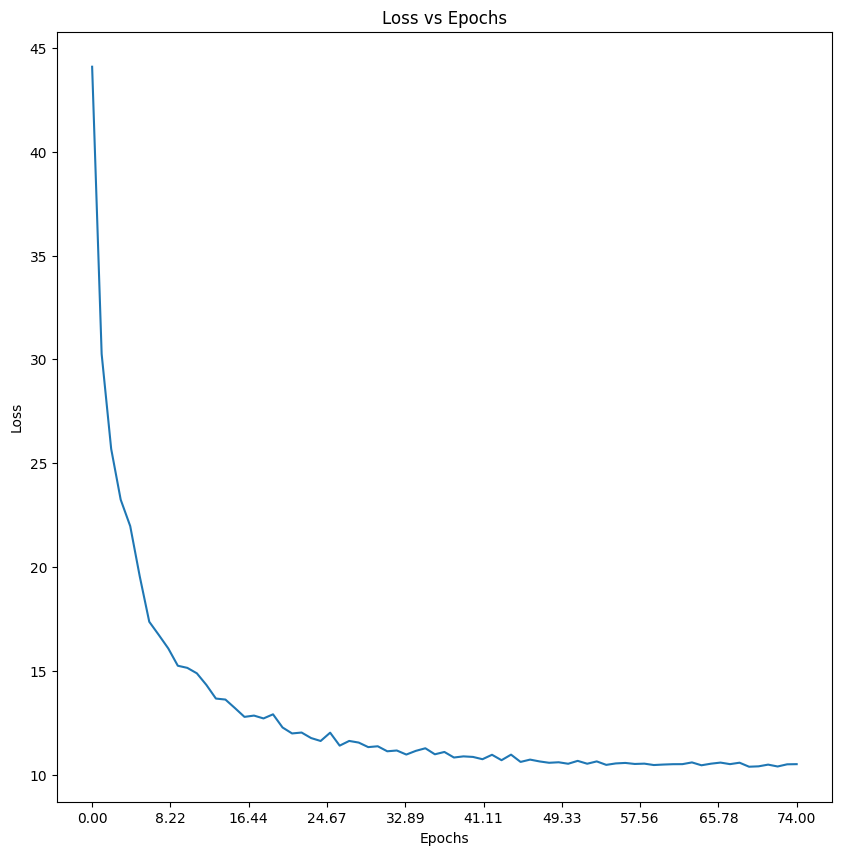

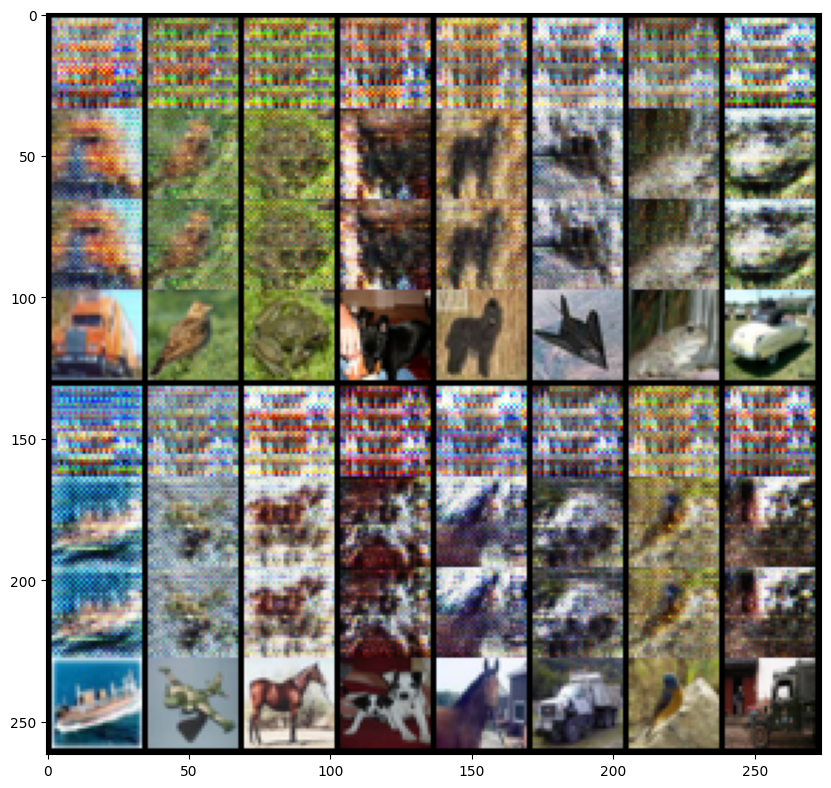

In [ ]:
new_losses = []
for l in stats.losses:
  new_losses.append((l[0], l[1].cpu()))
stats.losses = new_losses
if not os.path.exists("/content/files"):
  os.mkdir("/content/files")
stats.plot_loss("/content/files/loss_perc.png")
stats.show_images("/content/files/images_perc.png")